In this challenge, you need to create a machine learning model that will classify SMS messages as either "ham" or "spam". A "ham" message is a normal message sent by a friend. A "spam" message is an advertisement or a message sent by a company.

You should create a function called predict_message that takes a message string as an argument and returns a list. The first element in the list should be a number between zero and one that indicates the likeliness of "ham" (0) or "spam" (1). The second element in the list should be the word "ham" or "spam", depending on which is most likely.

For this challenge, you will use the SMS [Spam Collection dataset](http://www.dt.fee.unicamp.br/~tiago/smsspamcollection/). The dataset has already been grouped into train data and test data.

The first two cells import the libraries and data. The final cell tests your model and function. Add your code in between these cells.

In [64]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

%matplotlib inline

In [65]:
# get data files
TRAIN_DATA_URL = "https://raw.githubusercontent.com/beaucarnes/fcc_python_curriculum/master/sms/train-data.tsv"
TEST_DATA_URL  = "https://raw.githubusercontent.com/beaucarnes/fcc_python_curriculum/master/sms/valid-data.tsv"

train_file_path = tf.keras.utils.get_file("train-data.tsv", TRAIN_DATA_URL)
test_file_path  = tf.keras.utils.get_file("valid-data.tsv", TEST_DATA_URL)

# Normalization of data points
max_words = 1000
max_len = 500

In [66]:
df_train = pd.read_csv(train_file_path, sep="\t", header=None, names=['y', 'x'])
df_train.head()

,y,x
0,ham,ahhhh...just woken up!had a bad dream about u ...
1,ham,you can never do nothing
2,ham,"now u sound like manky scouse boy steve,like! ..."
3,ham,mum say we wan to go then go... then she can s...
4,ham,never y lei... i v lazy... got wat? dat day ü ...


Text(0.5, 1.0, 'Number of ham and spam messages')

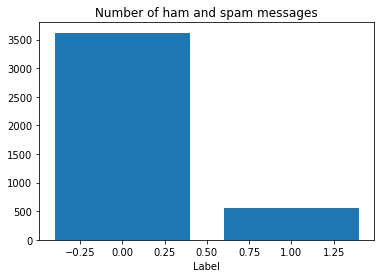

In [97]:
bar = df_train['y'].value_counts()

plt.bar(bar.index, bar)
plt.xlabel('Label')
plt.title('Number of ham and spam messages')

df_train.dropna()

In [67]:
df_test = pd.read_csv(test_file_path, sep="\t", header=None, names=['y', 'x'])
df_train.dropna()
df_test.head()

,y,x
0,ham,i am in hospital da. . i will return home in e...
1,ham,"not much, just some textin'. how bout you?"
2,ham,i probably won't eat at all today. i think i'm...
3,ham,don‘t give a flying monkeys wot they think and...
4,ham,who are you seeing?



**Categorial Data EDA**


In [68]:
df_train.dtypes
df_test.dtypes

y    object
x    object
dtype: object

In [70]:
print(len(df_train))
print(len(df_test))

4179
1392


Text(0.5, 1.0, 'Number of ham and spam messages')

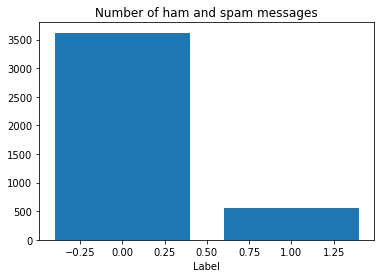

In [96]:
bar = df_train['y'].value_counts()

plt.bar(bar.index, bar)
plt.xlabel('Label')
plt.title('Number of ham and spam messages')

In [71]:
df_train["y"] = pd.factorize(df_train["y"])[0]
df_train.head()

,y,x
0,0,ahhhh...just woken up!had a bad dream about u ...
1,0,you can never do nothing
2,0,"now u sound like manky scouse boy steve,like! ..."
3,0,mum say we wan to go then go... then she can s...
4,0,never y lei... i v lazy... got wat? dat day ü ...


In [72]:
df_test["y"] = pd.factorize(df_test["y"])[0]
df_test.head()

,y,x
0,0,i am in hospital da. . i will return home in e...
1,0,"not much, just some textin'. how bout you?"
2,0,i probably won't eat at all today. i think i'm...
3,0,don‘t give a flying monkeys wot they think and...
4,0,who are you seeing?


In [73]:
y_train = df_train['y'].values
y_test = df_test['y'].values

array([0, 0, 0, ..., 1, 1, 0])

In [75]:
x_train = df_train['x']
x_test = df_test['x']

Since it's a NLP problem we have to do clean the dataset with nltk 



In [76]:
import nltk
import re
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords

In [77]:
nltk.download('stopwords') # download stopwords
nltk.download('wordnet')   # download vocab for lemmatizer
nltk.download('omw-1.4')  # Fix bug
stopwords_eng = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_txt(txt):
    txt = re.sub(r'([^\s\w])+', ' ', txt)
    txt = " ".join([lemmatizer.lemmatize(word) for word in txt.split()
                    if not word in stopwords_eng])
    txt = txt.lower()
    return txt
     
X_train = df_train['x'].apply(lambda x: clean_txt(x))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [78]:
from tensorflow.keras.preprocessing.text import Tokenizer

t = Tokenizer(num_words=max_words)
t.fit_on_texts(X_train)

In [79]:
from keras.utils import pad_sequences

sequences = t.texts_to_sequences(X_train)
sequences_matrix = pad_sequences(sequences, maxlen=max_len)

NLP Problem -> We have to use a LSTM NN with an Embedding layer for NLP Comprehension

In [86]:
i = tf.keras.layers.Input(shape=[max_len])
x = tf.keras.layers.Embedding(max_words, 50, input_length=max_len)(i)
x = tf.keras.layers.LSTM(128)(x)
x = tf.keras.layers.Dense(512, activation='elu')(x)
x = tf.keras.layers.Dense(1, activation='elu')(x)

model = tf.keras.models.Model(inputs=i, outputs=x)
model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 500)]             0         
                                                                 
 embedding_3 (Embedding)     (None, 500, 50)           50000     
                                                                 
 lstm_3 (LSTM)               (None, 128)               91648     
                                                                 
 dense_6 (Dense)             (None, 512)               66048     
                                                                 
 dense_7 (Dense)             (None, 1)                 513       
                                                                 
Total params: 208,209
Trainable params: 208,209
Non-trainable params: 0
_________________________________________________________________


In [91]:
earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience = 3)

In [92]:
history = model.fit(sequences_matrix, y_train, batch_size=128, epochs=10, validation_split=0.2, callbacks=[earlyStopping])

Epoch 1/10
27/27 [==============================] - 1s 39ms/step - loss: 0.0671 - accuracy: 0.9901 - val_loss: 0.1070 - val_accuracy: 0.9892
Epoch 2/10
27/27 [==============================] - 1s 34ms/step - loss: 0.0591 - accuracy: 0.9928 - val_loss: 0.1098 - val_accuracy: 0.9892
Epoch 3/10
27/27 [==============================] - 1s 34ms/step - loss: 0.0554 - accuracy: 0.9952 - val_loss: 0.1026 - val_accuracy: 0.9892
Epoch 4/10
27/27 [==============================] - 1s 36ms/step - loss: 0.0539 - accuracy: 0.9952 - val_loss: 0.1016 - val_accuracy: 0.9904
Epoch 5/10
27/27 [==============================] - 1s 34ms/step - loss: 0.0527 - accuracy: 0.9961 - val_loss: 0.1021 - val_accuracy: 0.9904
Epoch 6/10
27/27 [==============================] - 1s 34ms/step - loss: 0.0526 - accuracy: 0.9961 - val_loss: 0.1015 - val_accuracy: 0.9916
Epoch 7/10
27/27 [==============================] - 1s 35ms/step - loss: 0.0521 - accuracy: 0.9964 - val_loss: 0.1018 - val_accuracy: 0.9916


In [93]:
def preprocessing(X):
  x = X.apply(lambda x: clean_txt(x))
  x = t.texts_to_sequences(x)
  return pad_sequences(x, maxlen=max_len)

In [94]:
# function to predict messages based on model
# (should return list containing prediction and label, ex. [0.008318834938108921, 'ham'])
def predict_message(pred_text):
  p = model.predict(preprocessing(pd.Series([pred_text])))[0]

  return (p[0], ("ham" if p<0.5 else "spam"))


In [95]:
# Run this cell to test your function and model. Do not modify contents.
def test_predictions():
  test_messages = ["how are you doing today",
                   "sale today! to stop texts call 98912460324",
                   "i dont want to go. can we try it a different day? available sat",
                   "our new mobile video service is live. just install on your phone to start watching.",
                   "you have won £1000 cash! call to claim your prize.",
                   "i'll bring it tomorrow. don't forget the milk.",
                   "wow, is your arm alright. that happened to me one time too"
                  ]

  test_answers = ["ham", "spam", "ham", "spam", "spam", "ham", "ham"]
  passed = True

  for msg, ans in zip(test_messages, test_answers):
    prediction = predict_message(msg)
    if prediction[1] != ans:
      passed = False

  if passed:
    print("You passed the challenge. Great job!")
  else:
    print("You haven't passed yet. Keep trying.")

test_predictions()


1/1 [==============================] - 0s 28ms/step
You passed the challenge. Great job!
